<a href="https://colab.research.google.com/github/finiteautomata/hatespeech-analysis/blob/master/notebooks/Topics_of_hateful_articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [1]:
!pip install gdown pyLDAvis
!gdown -O coronavirus-v2.zip https://drive.google.com/uc?id=11AoDdhduHUv0uDfBsHhAwUhFtnmpG2q6
!7z x coronavirus-v2.zip

Downloading...
From: https://drive.google.com/uc?id=11AoDdhduHUv0uDfBsHhAwUhFtnmpG2q6
To: /content/coronavirus-v2.zip
155MB [00:02, 69.1MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 154796435 bytes (148 MiB)

Extracting archive: coronavirus-v2.zip
--
Path = coronavirus-v2.zip
Type = zip
Physical Size = 154796435

  0%    
Would you like to replace the existing file:
  Path:     ./CHANGELOG.md
  Size:     1284 bytes (2 KiB)
  Modified: 2020-08-01 22:48:52
with the file from archive:
  Path:     CHANGELOG.md
  Size:     1284 bytes (2 KiB)
  Modified: 2020-08-01 22:48:52
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? S

  0%    Everything is Ok

Files: 0
Size:       0
Compressed: 154796435


In [2]:
import json

with open("coronavirus-argentina-v2.json") as f:
    all_articles = json.load(f)


In [3]:
len(all_articles)

55110

Me quedo sólo con los que tengan más de 20 comentarios

In [4]:
articles = [art for art in all_articles if len(art["comments"]) >= 20]
print(len(articles))


6519


Calculamos cantidad de comentarios odiosos, "odio promedio", proporción de comentarios odiosos...

In [5]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


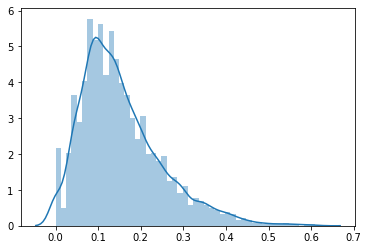

In [6]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

Me quedo con la cola larga a la derecha...

In [7]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

## Preprocesado de datos

Acá vamos a tokenizar los datos (convertirlos a unidades de análisis - en nuestro caso palabras) y luego a lematizarlas.

Primero, bajamos stopwords de nltk y el modelo de español de SpaCy

In [8]:

!python -m spacy download es
import nltk

nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosotros - vosotras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías - e

Ahora vamos a convertir cada palabra a sus respectivos lemas. Un ejemplo de qué hace esto:

In [10]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("es", disable=["parser", "ner"])

lemmas = [t.lemma_ for t in nlp("Tres tristes tigres comían trigo de un trigal")]

print(" ".join(lemmas))

Tres triste tigre comer trigo de uno trigal


In [11]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("es", disable=["parser", "ner"])

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


Sacamos las "stopwords" y también las que son puntuaciones

In [12]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Veamos un ejemplo de cómo eran y cómo quedan después del preprocesado

In [13]:
print(hateful_articles[0]["body"])
print("*" * 80 + '\n\n\n')
print(" ".join(lemmatized_data[0]))

El mosquito Aedes aegypti también podría ser un vector para mayaro

Mientras la atención continúa sobre el Covid-19, las personas contagiadas por dengue en nuestro país suman 41.754 en el período comprendido julio 2019 hasta el 9 de mayo de 2020, superando a los registrados en el año 2015-2016 en el mismo período, que hasta el momento era el que contaba con el mayor números de infectados con 41.402. Si la medición se toma por año calendario, en las primeras 19 semanas de 2020 se registraron 41.349 casos contra los 40.463 registrados en 2016. Así lo informó el Boletín Integrado de Vigilancia que elabora el Ministerio de Salud de la Nación y se conoció ayer. En el mismo lapso se consignó un total de 74.701 casos considerados como sospechosos.

En cuanto a la distribución de los infectados que fueron confirmados en la temporada 2015-2016, el mayor número de casos se dio en las primeras semanas del año, mientras que en la presente temporada el valor máximo se dio en la semana 17.

La tasa 

No es el mejor preprocesado pero...

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 3), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 4), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 1), (48, 12), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 4), (76, 1), (77, 1), (78, 1), (79, 1), (80, 8), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [15]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("topic_models.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

A calcular los tópicos

**ADVERTENCIA** ESTO TARDA MUCHO (alrededor de 30-40 minutos, dependiendo de la máquina que nos asigne Colab)

Corremos riesgo de que nos interrumpa el kernel por el tiempo que se toma... (se puede cambiar la cantidad de tópicos a buscar!)

In [16]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [17]:
import pickle

with open("topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [19]:
Y = [k.get_coherence() for k in coherence_models.values()]

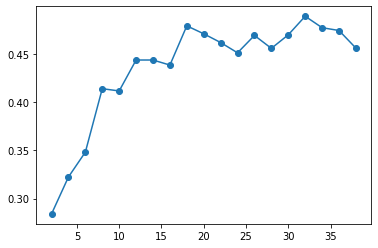

In [20]:
import matplotlib.pyplot as plt

plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 12 que tiene casi la misma coherencia...

In [21]:
lda_model = lda_models[12]

In [22]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.035*"país" + 0.013*"argentina" + 0.009*"millón" + 0.008*"uruguay" + '
  '0.008*"región" + 0.007*"brasil" + 0.007*"vacuno" + 0.007*"nuevo" + '
  '0.007*"mundo" + 0.006*"américa"'),
 (1,
  '0.031*"gustar" + 0.021*"twitter" + 0.019*"decir" + 0.019*"presidente" + '
  '0.018*"comentar" + 0.017*"fernández" + 0.016*"compartir" + 0.016*"2020" + '
  '0.016*"whatsapp" + 0.015*"facebook"'),
 (2,
  '0.023*"parir" + 0.015*"millón" + 0.014*"empresa" + 0.013*"pagar" + '
  '0.012*"ser" + 0.009*"social" + 0.008*"sector" + 0.007*"año" + 0.007*"deuda" '
  '+ 0.007*"trabajar"'),
 (3,
  '0.021*"parir" + 0.016*"ser" + 0.011*"presidente" + 0.009*"político" + '
  '0.009*"cristina" + 0.008*"comer" + 0.007*"haber" + 0.006*"kirchner" + '
  '0.006*"fernández" + 0.006*"gobernar"'),
 (4,
  '0.015*"ser" + 0.014*"mujer" + 0.010*"denunciar" + 0.009*"violencia" + '
  '0.009*"policía" + 0.009*"casar" + 0.008*"seguridad" + 0.007*"parir" + '
  '0.007*"hacer" + 0.007*"año"'),
 (5,
  '0.016*"juez" + 0.011*"argenti

In [23]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [26]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.289807  0.014635       1        1  21.233706
9      0.077748 -0.101548       2        1  14.016848
3     -0.090733 -0.243825       3        1  13.468377
8     -0.017194  0.069554       4        1   9.269591
10     0.318727  0.183790       5        1   8.865416
2     -0.215804 -0.007085       6        1   7.471139
1      0.327765 -0.203646       7        1   5.777868
4      0.082618 -0.339854       8        1   5.169680
5      0.092613  0.288987       9        1   4.550679
11    -0.119351  0.350345      10        1   4.359966
0     -0.305266  0.202183      11        1   3.364307
7     -0.440930 -0.213536      12        1   2.452418, topic_info=             Term          Freq         Total Category  logprob  loglift
179          país   4216.000000   4216.000000  Default  30.0000  30.0000
340        gustar   2583.000000   2583.000000  Default  29.0000  29.0000
391    presidente   4109.000000   4109.000000  Default  28.0000  28.0000
216           ser  35618.000000  35618.000000  Default  27.0000  27.0000
76          decir   7817.000000   7817.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
13337    cosechar     86.432213    134.725342  Topic12  -5.8752   3.2642
8210    propiedad     95.680626    293.853516  Topic12  -5.7735   2.5860
350          josé     94.679344    323.967377  Topic12  -5.7841   2.4779
280        carlos     94.745987    433.069702  Topic12  -5.7834   2.1884
365         mario     91.674324    250.898499  Topic12  -5.8163   2.7013

[824 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1517      4  0.995564   1.200
1528     10  0.993998    2013
5         4  0.002752    2020
5         5  0.029587    2020
5         6  0.099083    2020
...     ...       ...     ...
431       7  0.041367  último
431       8  0.028957  último
431       9  0.039529  último
431      10  0.027118  último
431      11  0.067107  último

[1839 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 4, 9, 11, 3, 2, 5, 6, 12, 1, 8])

In [ ]:
len(corpus), len(hateful_articles)

In [ ]:
num = 3


hateful_articles[num]["title"], lda_model.get_document_topics(corpus[num])